In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import cv2

In [3]:
data_dir = "/content/drive/My Drive/TF3 C3 W1 Data/"

In [5]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color=(255, 0, 0), thickness=5):
    """
    Adds a bounding box to an image.
    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.
    
    Args:
      image: a PIL.Image object.
      ymin: ymin of bounding box.
      xmin: xmin of bounding box.
      ymax: ymax of bounding box.
      xmax: xmax of bounding box.
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
    """
  
    image_width = image.shape[1]
    image_height = image.shape[0]
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)


def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image.
    
    Args:
      image: a PIL.Image object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
                           
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """
    
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                                 boxes[i, 2], color[i], thickness)


def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image (numpy array).
    
    Args:
      image: a numpy array object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
      display_str_list_list: a list of strings for each bounding box.
    
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """

    draw_bounding_boxes_on_image(image, boxes, color, thickness)
  
    return image#引自https://github.com/sasidhar-programmer/Tensorflow_Advance_Techniques

In [8]:
# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")


# utility to display a row of digits with their predictions
def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):

    n = len(images)

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
  
    for i in range(n):
      ax = fig.add_subplot(1, 10, i+1)
      bboxes_to_plot = []
      if (len(pred_bboxes) > i):
        bbox = pred_bboxes[i]
        bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
        bboxes_to_plot.append(bbox)
    
      if (len(bboxes) > i):
        bbox = bboxes[i]
        if bboxes_normalized == True:
          bbox = [bbox[0] * images[i].shape[1],bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0] ]
        bboxes_to_plot.append(bbox)

      img_to_draw = draw_bounding_boxes_on_image_array(image=images[i], boxes=np.asarray(bboxes_to_plot), color=[(255,0,0), (0, 255, 0)])
      plt.xticks([])
      plt.yticks([])
    
      plt.imshow(img_to_draw)

      if len(iou) > i :
        color = "black"
        if (iou[i][0] < iou_threshold):
          color = "red"
        ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes)
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)#该区域引自https://github.com/sasidhar-programmer/Tensorflow_Advance_Techniques

9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Functiona (None, 7, 7, 1280)   2257984     input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1280)         0           mobilenetv2_1.00_224[0][0]       
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1280)         0           global_average_pooling2d[0][0]   
_______________________________

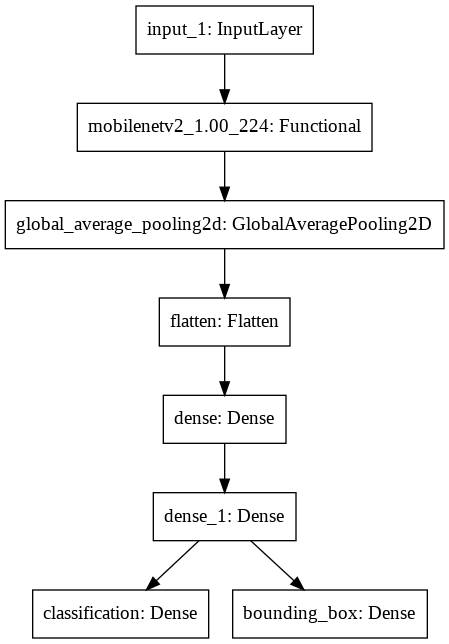

In [9]:
def feature_extraction(inputs):
  feature_extractor=tf.keras.applications.MobileNetV2(input_shape=(224,224,3),include_top=False, weights='imagenet')(inputs)
  return feature_extractor

def classification_layer(inputs):
  x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1024, activation="relu")(x)
  x = tf.keras.layers.Dense(512, activation="relu")(x)
  return x

def bounding_box_regression(x):
  x=tf.keras.layers.Dense(units='4',name = 'bounding_box')(x)
  return x

inputs = tf.keras.Input(shape=(224,224,3))
extracted_features = feature_extraction(inputs)
x= classification_layer(extracted_features)
bbox_location=bounding_box_regression(x)
category = tf.keras.layers.Dense(200, activation="softmax",name = 'classification')(x)
model = tf.keras.Model(inputs=inputs, outputs=[category,bbox_location])
opt=tf.keras.optimizers.SGD( learning_rate=0.01, momentum=0.9, name='SGD')
model.compile(optimizer=opt, loss={'classification' : 'categorical_crossentropy','bounding_box' : 'mse'},metrics = {'classification' : 'accuracy','bounding_box' : 'mse'})
model.summary()
tf.keras.utils.plot_model(model) 

In [27]:
def read_image_tfds(image,label):
    #if tf.executing_eagerly():
      #for images, (labels, bboxes) in data:
        #image = images.numpy()
        #label = labels.numpy()
        #bbox = bboxes.numpy()
        #break
    #image=data["image"]
    #bbox=data["bbox"]
    #print(type(label))
    class_label=label[0]
    bbox=label[1]
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)
    #label=data["label"]

    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    image = tf.image.resize(image, (224, 224,))

    image = image/127.5
    image -= 1

    bbox_list = [bbox[0] / factor_x , 
                 bbox[1] / factor_y, 
                 bbox[2] / factor_x , 
                 bbox[3] / factor_y]
    #sess = tf.InteractiveSession()
    #tf.Print(bbox,bbox[0] / factor_x,bbox[1] / factor_y)
    #init_op = tf.global_variables_initializer()
    #with tf.Session() as sess:
      #sess.run(init) #execute init_op
    #print the random values that we sample
      #print(sess.run([bbox]))
      #print(sess.run(bbox[0] / factor_x))
    print(class_label,bbox_list)
    return image, (class_label,bbox_list)
def read_image_with_shape(image, lb):
    original_image = image
    
    image, lbs = read_image_tfds(image, lb)
    
    return original_image, image, lbs
def read_image_tfds_with_original_bbox(data):
    image = data["image"]
    bbox = data["bbox"]
    label=data["label"]
    shape = tf.shape(image)
    factor_x = tf.cast(shape[1], tf.float32) 
    factor_y = tf.cast(shape[0], tf.float32)

    bbox_list = [bbox[1] * factor_x , 
                 bbox[0] * factor_y, 
                 bbox[3] * factor_x, 
                 bbox[2] * factor_y]
    return image, (tf.one_hot(label,200),bbox_list)
def dataset_to_numpy_with_original_bboxes_util(dataset, batch_size=0, N=0):

    normalized_dataset = dataset.map(read_image_with_shape)
    if batch_size > 0:
        normalized_dataset = normalized_dataset.batch(batch_size)
  
    if N > 0:
        normalized_dataset = normalized_dataset.take(N)

    if tf.executing_eagerly():
        ds_original_images, ds_images, ds_bboxes = [], [], []
        
    for original_images, images, labeles in normalized_dataset:
        bboxes=labeles[1]
        ds_images.append(images.numpy())
        ds_bboxes.append(bboxes.numpy())
        ds_original_images.append(original_images.numpy())

    return np.array(ds_original_images), np.array(ds_images), np.array(ds_bboxes)
    
def dataset_to_numpy_util(image,label, batch_size=0, N=0):
    lb=label[0]
    bbox=label[1]

    # eager execution: loop through datasets normally
    take_dataset = dataset.shuffle(1024)

    if batch_size > 0:
        take_dataset = take_dataset.batch(batch_size)
  
    if N > 0:
        take_dataset = take_dataset.take(N)
  
    if tf.executing_eagerly():
        ds_images, ds_bboxes = [], []
        for images, bboxes in take_dataset:
            ds_images.append(images.numpy())
            ds_bboxes.append(bboxes.numpy())
        
    return (np.array(ds_images), np.array(ds_bboxes))

In [11]:
def get_visualization_training_dataset():      
    dataset, info = tfds.load("caltech_birds2010", split="train", with_info=True, download = True, data_dir=data_dir)
    print(info)
    visualization_training_dataset = dataset.map(read_image_tfds_with_original_bbox,num_parallel_calls=16)
    
    return visualization_training_dataset

def get_visualization_validation_dataset():
    dataset = tfds.load("caltech_birds2010", split="test", try_gcs=True, data_dir=data_dir)
    visualization_validation_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)
    
    return visualization_validation_dataset

visualization_training_dataset = get_visualization_training_dataset()
#(visualization_training_images, visualization_training_bboxes) = dataset_to_numpy_util(visualization_training_dataset, N=5)
visualization_validation_dataset = get_visualization_validation_dataset()
#(visualization_validation_images, visualization_validation_bboxes) = dataset_to_numpy_util(visualization_validation_dataset, N=5)
print(len(visualization_training_dataset),len(visualization_validation_dataset))#important

tfds.core.DatasetInfo(
    name='caltech_birds2010',
    version=0.1.1,
    description='Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
of 200 bird species (mostly North American). The total number of 
categories of birds is 200 and there are 6033 images in the 2010 
dataset and 11,788 images in the 2011 dataset.
Annotations include bounding boxes, segmentation labels.',
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=200),
        'label_name': Text(shape=(), dtype=tf.string),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
    }),
    total_num_examples=6033,
    splits={
        'test': 3033,
        'train': 3000,
    },
    supervised_keys=('ima

In [12]:
BATCH_SIZE = 64
def read_image_tfds(image,label):
    #if tf.executing_eagerly():
      #for images, (labels, bboxes) in data:
        #image = images.numpy()
        #label = labels.numpy()
        #bbox = bboxes.numpy()
        #break
    #image=data["image"]
    #bbox=data["bbox"]
    #print(type(label))
    class_label=label[0]
    bbox=label[1]
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)
    #label=data["label"]

    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    image = tf.image.resize(image, (224, 224,))

    image = image/127.5
    image -= 1

    bbox_list = [bbox[0] / factor_x , 
                 bbox[1] / factor_y, 
                 bbox[2] / factor_x , 
                 bbox[3] / factor_y]
    #sess = tf.InteractiveSession()
    #tf.Print(bbox,bbox[0] / factor_x,bbox[1] / factor_y)
    #init_op = tf.global_variables_initializer()
    #with tf.Session() as sess:
      #sess.run(init) #execute init_op
    #print the random values that we sample
      #print(sess.run([bbox]))
      #print(sess.run(bbox[0] / factor_x))
    print(class_label,bbox_list)
    return image, (class_label,bbox_list)
def get_training_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(-1) 
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    return dataset

training_dataset = get_training_dataset(visualization_training_dataset)
validation_dataset = get_validation_dataset(visualization_validation_dataset) 

Tensor("args_1:0", shape=(200,), dtype=float32) [<tf.Tensor 'truediv_1:0' shape=() dtype=float32>, <tf.Tensor 'truediv_2:0' shape=() dtype=float32>, <tf.Tensor 'truediv_3:0' shape=() dtype=float32>, <tf.Tensor 'truediv_4:0' shape=() dtype=float32>]
Tensor("args_1:0", shape=(200,), dtype=float32) [<tf.Tensor 'truediv_1:0' shape=() dtype=float32>, <tf.Tensor 'truediv_2:0' shape=() dtype=float32>, <tf.Tensor 'truediv_3:0' shape=() dtype=float32>, <tf.Tensor 'truediv_4:0' shape=() dtype=float32>]


In [13]:

import os
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
  from google.colab import auth
  # Authenticates the Colab machine and also the TPU using your
  # credentials so that they can access your private GCS buckets.
  auth.authenticate_user()

In [14]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [16]:
EPOCHS = 45# 45
steps_per_epoch = 47#64 is batch size
validation_steps = 48

history = model.fit(x=training_dataset,steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS)

Epoch 1/45
47/47 [==============================] - 34s 691ms/step - loss: 0.0353 - classification_loss: 0.0159 - bounding_box_loss: 0.0194 - classification_accuracy: 0.9973 - bounding_box_mse: 0.0194 - val_loss: 3.6439 - val_classification_loss: 3.5972 - val_bounding_box_loss: 0.0467 - val_classification_accuracy: 0.2562 - val_bounding_box_mse: 0.0467
Epoch 2/45
47/47 [==============================] - 32s 692ms/step - loss: 0.0303 - classification_loss: 0.0127 - bounding_box_loss: 0.0176 - classification_accuracy: 0.9973 - bounding_box_mse: 0.0176 - val_loss: 3.4994 - val_classification_loss: 3.4693 - val_bounding_box_loss: 0.0301 - val_classification_accuracy: 0.2816 - val_bounding_box_mse: 0.0301
Epoch 3/45
47/47 [==============================] - 32s 695ms/step - loss: 0.0310 - classification_loss: 0.0123 - bounding_box_loss: 0.0188 - classification_accuracy: 0.9977 - bounding_box_mse: 0.0188 - val_loss: 3.4444 - val_classification_loss: 3.3922 - val_bounding_box_loss: 0.0523 - va

In [17]:
model.save("birds.h5")
from google.colab import files

files.download("birds.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

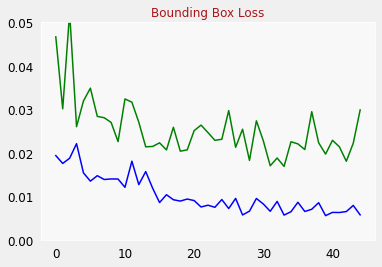

In [20]:

plot_metrics("bounding_box_loss", "Bounding Box Loss", ylim=0.05)

In [33]:
def intersection_over_union(pred_box, true_box):
    print(type(pred_box))
    array_pred_box=np.array(pred_box)
    array_true_box=np.array(true_box)

    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(array_pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(array_true_box, 4, axis = 1)

    #Calculate coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(xmin_pred, xmin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #Calculates area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred + 1) * (ymax_pred - ymin_pred + 1)
    true_box_area = (xmax_true - xmin_true + 1) * (ymax_true - ymin_true + 1)

    #Calculates overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap) + 1,0)  * np.maximum((ymax_overlap - ymin_overlap) + 1, 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    #Updates iou score
    iou = overlap_area / union_area

    return iou

#Makes predictions
original_images, normalized_images, normalized_bboxes = dataset_to_numpy_with_original_bboxes_util(visualization_validation_dataset, N=500)
predicted_bboxes = model.predict(normalized_images, batch_size=32)


#Calculates IOU and reports true positives and false positives based on IOU threshold
iou = intersection_over_union(predicted_bboxes[1], normalized_bboxes)
iou_threshold = 0.6

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

Tensor("args_1:0", shape=(200,), dtype=float32) [<tf.Tensor 'truediv_1:0' shape=() dtype=float32>, <tf.Tensor 'truediv_2:0' shape=() dtype=float32>, <tf.Tensor 'truediv_3:0' shape=() dtype=float32>, <tf.Tensor 'truediv_4:0' shape=() dtype=float32>]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


<class 'numpy.ndarray'>
Number of predictions where iou > threshold(0.6): 311
Number of predictions where iou < threshold(0.6): 189


<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[[0.472      0.37066665 0.7        0.50133336]
 [0.18618618 0.2        0.5855856  0.726     ]
 [0.25382262 0.124      0.7003058  0.822     ]
 [0.154      0.23943663 0.85       0.85211265]
 [0.39030612 0.236      0.82653064 0.542     ]
 [0.254      0.08864266 0.756      0.7894737 ]
 [0.3898305  0.458      0.6588983  0.784     ]
 [0.444      0.38323355 0.61       0.6706587 ]
 [0.56       0.3525     0.77       0.805     ]
 [0.404      0.0955414  0.646      0.6878981 ]]
[[0.63177025]
 [0.7499133 ]
 [0.52984244]
 [0.5902725 ]
 [0.5077062 ]
 [0.7278972 ]
 [0.6915774 ]
 [0.5590429 ]
 [0.46026963]
 [0.5534341 ]]
[[0.3635053  0.2846826  0.5316819  0.50781137]
 [0.30600047 0.14814022 0.5471862  0.71462214]
 [0.39914468 0.26443577 0.4623707  0.69449323]
 [0.32503635 0.18974268 0.58660656 0.6846141 ]
 [0.21403572 0.23797664 0.43293688 0.6246459 ]
 [0.30530962 0.25666723 0.746926   0.6306027 ]
 [0.40707764 0.39289027 0.42341706 0.56195486]
 [0.5808828

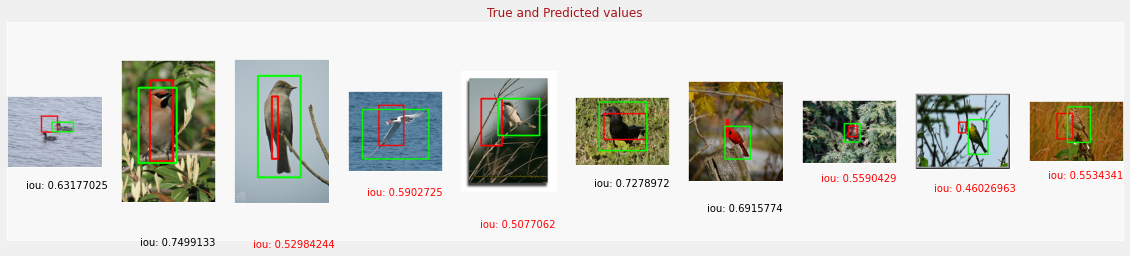

In [43]:
n = 10
indexes = np.random.choice(len(predicted_bboxes[1]), size=n)
print(type(normalized_images),type(normalized_bboxes))
original_image_to_draw=original_images[indexes]
iou_to_draw = iou[indexes,:]
print(normalized_bboxes[indexes,:])
print(iou_to_draw)
print(predicted_bboxes[1][indexes])
display_digits_with_boxes(original_image_to_draw, predicted_bboxes[1][indexes], normalized_bboxes[indexes,:], iou_to_draw, "True and Predicted values", bboxes_normalized=True)